# Simulated data analysis

## Setup

In [1]:
# simulation setup

import numpy as np
import pandas as pd

n = 100000
p = 6
np.random.seed(42)

# fixed part
x = np.random.rand(n, p)
betas = np.random.normal(0, 5, size = p+1)
print('True coefficients:', betas)
true_f = betas[0] + np.dot(x, betas[1:])

# stochastic part
stn = 5
noise_std = np.sqrt(np.var(true_f)/stn)
noise = np.random.normal(0, noise_std, size = n)
y = true_f + noise

# save as pandas dataframe
xy = pd.DataFrame(x, columns = ["x" + str(i+1) for i in range(p)])
xy["y"] = y

True coefficients: [-0.44329024  3.45930833 -0.17094764 -5.28926666 -3.07245074 -5.90810057
  0.75680427]


In [2]:
xy.head()

,x1,x2,x3,x4,x5,x6,y
0,0.374540,0.950714,0.731994,0.598658,0.156019,0.155995,-5.469679
1,0.058084,0.866176,0.601115,0.708073,0.020584,0.969910,-3.749033
2,0.832443,0.212339,0.181825,0.183405,0.304242,0.524756,0.307718
3,0.431945,0.291229,0.611853,0.139494,0.292145,0.366362,-5.777635
4,0.456070,0.785176,0.199674,0.514234,0.592415,0.046450,-4.752492


In [3]:
# spark setup
import os
import sys

os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable
os.environ["PYARROW_IGNORE_TIMEZONE"] = "1"

# spark session
from pyspark.sql import SparkSession
spark = SparkSession \
    .builder \
    .master('local[4]') \
    .appName('This Spark session') \
    .config('spark.sql.repl.eagerEval.enabled', True) \
    .config('spark.sql.execution.arrow.pyspark.enabled', False) \
    .getOrCreate()

In [4]:
spark

In [5]:
# pyspark imports
from pyspark.sql.functions import pandas_udf, col, lit, pow as spow
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline

# other libraries
import pandas as pd
import numpy as np
from scipy.linalg import solve_triangular

## Data preparation

In [6]:
# pyspark dataframe
df = spark.createDataFrame(xy)

n = df.count()
print(f'The dataset has {n} rows and {len(df.columns)} columns.\n')
df.printSchema()

The dataset has 100000 rows and 7 columns.

root
 |-- x1: double (nullable = true)
 |-- x2: double (nullable = true)
 |-- x3: double (nullable = true)
 |-- x4: double (nullable = true)
 |-- x5: double (nullable = true)
 |-- x6: double (nullable = true)
 |-- y: double (nullable = true)



In [7]:
# create feature preprocessing pipeline

# combine features in a single vector
features = df.columns[:-1]
assembler = VectorAssembler(inputCols = features, outputCol = 'X')

# put everything in a pipeline , to be used after data splitting
preproc = Pipeline(stages = [assembler])

In [8]:
# obtain two equal splits
s1, s2 = df.randomSplit([0.5, 0.5], seed=42)

n1 = s1.count()
n2 = s2.count()
nn = min(n1, n2)

s1 = s1.limit(nn)
s2 = s2.limit(nn)

print(f'Each split has {nn} rows.')

Each split has 49809 rows.


In [9]:
# final preparation step
s1 = preproc.fit(s1).transform(s1).select('X','y')
s2 = preproc.fit(s2).transform(s2).select('X','y')

s1.printSchema()

root
 |-- X: vector (nullable = true)
 |-- y: double (nullable = true)



## Analysis

### Linear model

In [10]:
# functions for liner model estimation and prediction

def map_lm(row):
    """Calculate x*t(x) and x*y for each row"""
    
    x = [1]
    x.extend(row['X'].toArray())
    x = np.array(x)
    y = row["y"]
    out = [np.outer(x, x), x*y]    
    
    return out

def get_prediction_lm(row, beta):
    """Calculate predictions for a row from estimated linear model"""
    
    x = row["X"].toArray()
    ypred = beta[1] + np.dot(x, beta[1:])
    
    return (row + (float(ypred),))

def cholesky_normal_equations(xtx, xty):
    """Calculate the solution to the normal equation via Cholesky scomposition"""
    
    if not np.all(np.linalg.eigvals(xtx) > 0):
        print('Adjusting matrix...')
        #adj = np.abs(np.min(np.linalg.eigvals(xtx)))+0.00001
        xtx = xtx + np.diag(np.repeat(0.001, xtx.shape[0]))
    
    L = np.linalg.cholesky(xtx) 
    z = solve_triangular(L, xty, lower = True) 
    beta_hat = solve_triangular(L, z, lower = True, trans = "T")
    
    return beta_hat    

def get_beta_sd(xtx, sigma2):
    '''
    calculates standard deviation of linear model coefficients 
    using Cholesky decomposition
    '''
    
    L = np.linalg.cholesky(xtx) 
    z1 = solve_triangular(L, np.eye(xtx.shape[0]), lower = True)
    z2 = solve_triangular(L.T, np.eye(xtx.shape[0]), lower = False)
    xtx_inv = np.dot(z2, z1)
    sd_beta = np.sqrt(np.diag(sigma2*xtx_inv))
    
    return sd_beta

In [11]:
# calculate t(X)X and t(X)y for the two splits
xtx_lm_s1, xty_lm_s1 = s1.rdd.map(lambda row: map_lm(row)).reduce(lambda a,b: (a[0]+b[0], a[1]+b[1]))
xtx_lm_s2, xty_lm_s2 = s2.rdd.map(lambda row: map_lm(row)).reduce(lambda a,b: (a[0]+b[0], a[1]+b[1]))

In [12]:
# solve normal equations
beta_hat_lm_s1 = cholesky_normal_equations(xtx_lm_s1, xty_lm_s1)
beta_hat_lm_s2 = cholesky_normal_equations(xtx_lm_s2, xty_lm_s2)

#beta_hat_lm_s1, beta_hat_lm_s2

In [13]:
# calculate predictions from linear model
o1 = s1.rdd.map(lambda row:get_prediction_lm(row, beta_hat_lm_s2)).toDF(['X', 'y', 'yhat'])
o2 = s2.rdd.map(lambda row:get_prediction_lm(row, beta_hat_lm_s1)).toDF(['X', 'y', 'yhat'])

In [14]:
# functions for conformal prediction

@pandas_udf("double")
def get_abs_error(yreal: pd.Series, ypred: pd.Series) -> pd.Series:
    """calculate absolute prediction error"""
    return np.abs(yreal-ypred)

@pandas_udf("double")
def find_quantile(err: pd.Series) -> pd.Series:
    """given ordered absolute errors, calculate ROO empirical quantile"""
    
    level = 0.95
    m = int(np.ceil(len(err)*level))
    out = [err.drop([i]).values[m-1] for i in range(len(err))]
    
    return pd.Series(out)

def ROOsplitconformal(df):
    """
    given a Spark dataframe with columns y and yhat,
    calculate and sort absolute errors, 
    find ROO empirical quantiles,
    calculate lower and upper bounds for ROO split conformal prediction intervals    
    """
    
    out = df \
            .withColumn("abs_error", get_abs_error(col("y"), col("yhat"))).sort(col("abs_error")) \
            .withColumn("ROO_eq", find_quantile(col("abs_error"))) \
            .withColumn("lower", col("yhat")-col("ROO_eq")) \
            .withColumn("upper", col("yhat")+col("ROO_eq"))
    
    return out

In [15]:
# ROO split conformal predictive intervals
o1 = o1.transform(ROOsplitconformal)
o2 = o2.transform(ROOsplitconformal)

In [16]:
# calculate betas standard error

# get s2 for each split
sigma2_hat1 = o1.withColumn('rsse', spow((col('yhat')-col('y')), 2)).select('rsse').groupBy().sum().collect()[0][0]/(nn-1)
sigma2_hat2 = o2.withColumn('rsse', spow((col('yhat')-col('y')), 2)).select('rsse').groupBy().sum().collect()[0][0]/(nn-1)

# get betas sd for each split
beta_hat_lm_s1_sd = get_beta_sd(xtx_lm_s1, sigma2_hat1)
beta_hat_lm_s2_sd = get_beta_sd(xtx_lm_s2, sigma2_hat2)

#beta_hat_lm_s1_sd, beta_hat_lm_s2_sd

In [17]:
# merge the splits
res_lm = o1.union(o2)

In [18]:
# functions for results evaluation

@pandas_udf("double")
def rmse(yreal: pd.Series, ypred: pd.Series) -> float:
    return np.sqrt(np.mean((yreal-ypred)**2))

@pandas_udf("double")
def coverage(yreal: pd.Series, lower: pd.Series, upper: pd.Series) -> float:
    return np.mean(((yreal>lower) & (yreal<upper))*1.0)

@pandas_udf("double")
def avg_length(lower: pd.Series, upper: pd.Series) -> float:
    return np.mean(upper - lower)

In [19]:
# evaluate results
metrics_lm = res_lm.select(
    lit('linear').alias('model'),
    rmse(col('y'), col('yhat')).alias('rmse'),
    coverage(col('y'), col('lower'), col('upper')).alias('coverage'), 
    avg_length(col('lower'), col('upper')).alias('avg_length'))

In [20]:
metrics_lm.show()

+------+-----------------+------------------+-----------------+
| model|             rmse|          coverage|       avg_length|
+------+-----------------+------------------+-----------------+
|linear|4.088984186384552|0.9500090345118352|8.869898319485893|
+------+-----------------+------------------+-----------------+



### Additive model

In [21]:
# functions for additive model estimation and prediction

def ncs_elem(x, xk):
    """given a feature and knots, calulates basis functtion"""
    
    out = (((xk-1/2)**2-1/12)*((x-1/2)**2)-1/12)/4 - ((np.abs(x-xk)-1/2)**4-1/2*(np.abs(x-xk)-1/2)**2 + 7/240)/24
    
    return out

def splS(knots):
    """define S penalty matrix for a single term"""
    
    q = len(knots)+2
    S = np.zeros([q,q])
    k = np.array(knots)
    S[2:, 2:] = ncs_elem(k[:,None], k)
    
    return S
    
def get_bigS(knots, lam = 0.01):
    """Obtain global penalty matrix"""
    
    Slist = []
    for i in range(p):
        q = len(knots)+1
        S = np.zeros([p*q, p*q])
        S2 = np.zeros([len(S)+1, len(S)+1])
        S[i*q:(i+1)*q, i*q:(i+1)*q] = splS(knots)[1:,1:]
        S2[1:,1:] = S
        Slist.append(S2)
    bigS = sum(lam*elem for elem in Slist)
    
    return bigS

def map_gam(row, knots):
    """for each row, compute natural cubic splines basis expansion for x then calculate x*t(x) and x*y"""
    
    nx = [1]
    x = row["X"].toArray()
    y = row["y"]
    for j, xij in enumerate(x):
        nx.append(xij)
        nx.extend([ncs_elem(xij, knot) for knot in knots])
    x = np.array(nx)
    out = [np.outer(x, x), x*y]

    return out

def get_prediction_gam(row, beta, knots):
    """Calculate predictions for estimated additive model"""
    
    nx = []
    x = row["X"].toArray()
    for j, xij in enumerate(x):
        nx.append(xij)
        nx.extend([ncs_elem(xij, knot) for knot in knots])
    x = np.array(nx)
    ypred = beta[1] + np.dot(x, beta[1:])
    
    return (row + (float(ypred),))

In [22]:
knots1 = np.linspace(0.05, 0.95, 10)

In [23]:
# calculate t(X)X and t(X)y for the two splits
xtx_gam1_s1, xty_gam1_s1 = s1.rdd.map(lambda row: map_gam(row, knots1)).reduce(lambda a,b: (a[0]+b[0], a[1]+b[1]))
xtx_gam1_s2, xty_gam1_s2 = s2.rdd.map(lambda row: map_gam(row, knots1)).reduce(lambda a,b: (a[0]+b[0], a[1]+b[1]))

In [24]:
# solve normal equations using LU decomposition since penalized matrix is not symmetric
S = get_bigS(knots = knots1, lam = 4)
beta_hat_gam1_s1 = np.linalg.solve(xtx_gam1_s1 + S, xty_gam1_s1)
beta_hat_gam1_s2 = np.linalg.solve(xtx_gam1_s2 + S, xty_gam1_s2)

#beta_hat_gam1_s1, beta_hat_gam1_s2

In [25]:
# calculate predictions from additive model
o1 = s1.rdd.map(lambda row:get_prediction_gam(row, beta_hat_gam1_s2, knots1)).toDF(['X', 'y', 'yhat'])
o2 = s2.rdd.map(lambda row:get_prediction_gam(row, beta_hat_gam1_s1, knots1)).toDF(['X', 'y', 'yhat'])

In [26]:
# ROO split conformal predictive intervals
o1 = o1.transform(ROOsplitconformal)
o2 = o2.transform(ROOsplitconformal)

# merge the splits
res_gam1 = o1.union(o2)

In [27]:
# evaluate results
metrics_gam1 = res_gam1.select(
    lit('additive').alias('model'),
    rmse(col('y'), col('yhat')).alias('rmse'),
    coverage(col('y'), col('lower'), col('upper')).alias('coverage'), 
    avg_length(col('lower'), col('upper')).alias('avg_length'))

metrics = metrics_lm.union(metrics_gam1)

In [28]:
metrics.show()

+--------+-----------------+------------------+-----------------+
|   model|             rmse|          coverage|       avg_length|
+--------+-----------------+------------------+-----------------+
|  linear|4.088984186384552|0.9500090345118352|8.869898319485893|
|additive|4.094623194083175|0.9500090345118352|8.881213647532158|
+--------+-----------------+------------------+-----------------+



## Visualization

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

# helper functions
knots = np.linspace(0.05, 0.95, 10)
num = ["x" + str(i+1) for i in range(p)]

def plot_lm(beta_hat_lm, beta_hat_lm_sd):

    fig, ax = plt.subplots(figsize=(1.618*5, 5))
    fig.suptitle('Linear model - Estimated coefficients', size=18)
    sns.barplot(ax=ax, y=num, x=beta_hat_lm[1:], orient='h', color='tab:blue')
    y_coords = [p.get_y() + 0.5 * p.get_height() for p in ax.patches]
    x_coords = [p.get_width() for p in ax.patches]
    ax.errorbar(x=x_coords, y=y_coords, xerr=beta_hat_lm_sd[1:], fmt="none", c="k")
    ax.axvline(0, 0, 1, linestyle='dashed', linewidth=0.8, color='darkgrey')
    fig.tight_layout()

def ncs_elem(x, xk):
    """given a feature and knots, calulates basis functtion"""
    out = (((xk-1/2)**2-1/12)*((x-1/2)**2)-1/12)/4 - ((np.abs(x-xk)-1/2)**4-1/2*(np.abs(x-xk)-1/2)**2 + 7/240)/24
    return out
    
def plot_gam(gam_coefs, sharey=False):
    
    coefs = np.split(np.delete(gam_coefs, [0]), 6)

    x = np.linspace(0, 1, 100)
    nx = []
    nx.append(x)
    nx.extend([ncs_elem(x, knot) for knot in knots])
    nx = np.array(nx).T

    fig, axs = plt.subplots(2, 3, figsize = [1.618*6, 6], sharex=True, sharey=sharey)
    fig.suptitle('Additive model - Estimated effects', size=18)
    for i, ax in enumerate(axs.ravel()):
        y_gam = np.dot(nx, coefs[i])
        plotdata = pd.DataFrame({'x':x, 'y':y_gam})
        sns.lineplot(ax=ax, x='x', y='y', data=plotdata)
        ax.set_title(num[i], size=12)
    
    plt.show()
       
def plot_gam_lm(gam_coefs, lin_coefs, lin_coefs_sd, sharey=False, height=6, save=False):
    
    coefs = np.split(np.delete(gam_coefs, [0]), 6)

    x = np.linspace(0, 1, 100)
    nx = []
    nx.append(x)
    nx.extend([ncs_elem(x, knot) for knot in knots])
    nx = np.array(nx).T

    fig, axs = plt.subplots(2, 3, figsize = (1.618*height, height), sharex=True, sharey=sharey)
    fig.suptitle('Additive model - Estimated effects', size=18)
    for i, ax in enumerate(axs.ravel()):
        y_gam = np.dot(nx, coefs[i])
        y_lin = np.dot(x, lin_coefs[i+1])
        y1 = np.dot(x, lin_coefs[i+1] - 1.96* lin_coefs_sd[i+1])
        y2 = np.dot(x, lin_coefs[i+1] + 1.96* lin_coefs_sd[i+1])
        plotdata = pd.DataFrame({'x':x, 'additive':y_gam, 'linear':y_lin})
        sns.lineplot(ax=ax, x='x', y='y', hue='model', data=pd.melt(plotdata, id_vars='x', var_name='model', value_name='y'))
        ax.fill_between(x=plotdata.x, y1=y1, y2=y2, color='orange', alpha=0.1)
        ax.axhline(0, 0, 1, linestyle='dashed', linewidth=0.8, color='darkgrey')
        ax.set_title(num[i], size=12)
        ax.set(xlabel='', ylabel='')
        ax.get_legend().remove()
    
    handles, labels = axs[1,1].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right')
    fig.tight_layout()
    if save:
        fig.savefig('figures/airbnb_gam.png', bbox_inches='tight')

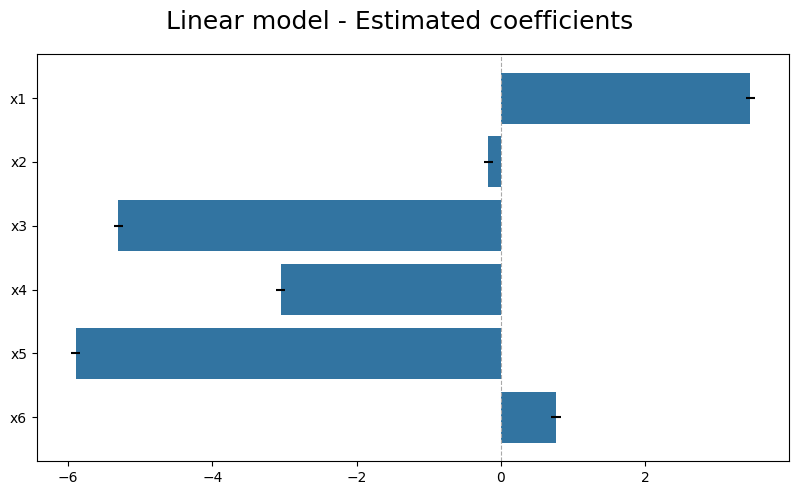

In [30]:
beta_hat_lm = np.mean(np.array([beta_hat_lm_s1, beta_hat_lm_s2]), axis = 0)
beta_hat_lm_sd = np.mean(np.array([beta_hat_lm_s1_sd, beta_hat_lm_s2_sd]), axis = 0)

plot_lm(beta_hat_lm, beta_hat_lm_sd)

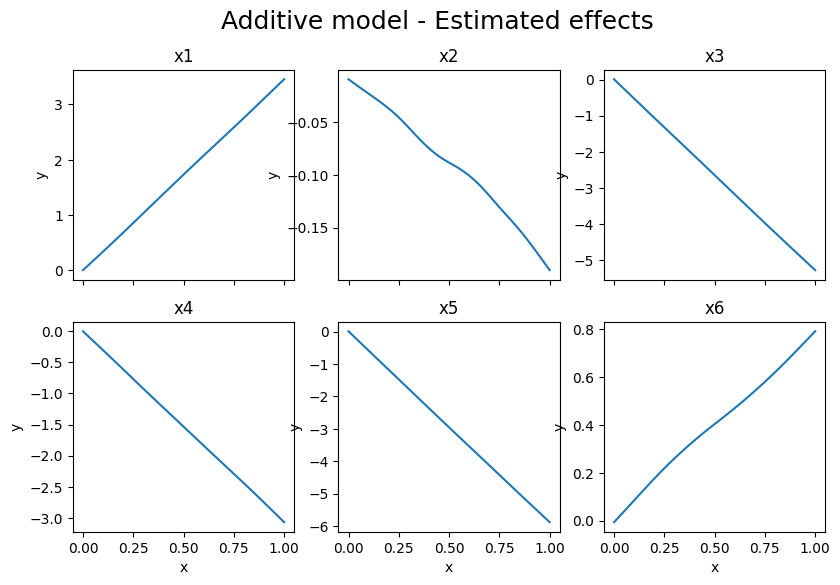

In [31]:
beta_hat_gam = np.mean(np.array(([beta_hat_gam1_s1, beta_hat_gam1_s2])), axis = 0)

plot_gam(beta_hat_gam)

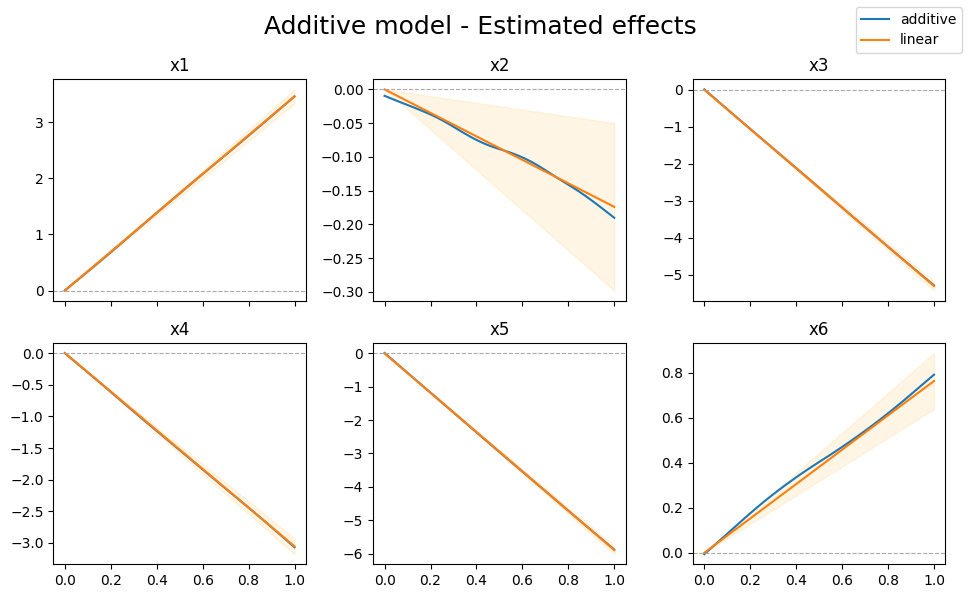

In [32]:
plot_gam_lm(beta_hat_gam, beta_hat_lm, beta_hat_lm_sd)